<a href="https://colab.research.google.com/github/d-kleine/Advent_of_HayStack/blob/main/1_Advent_of_Haystack_Enhancing_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advent of Haystack: Day 1
_Make a copy of this Colab to start!_

In this first challenge, we are going to build a pipeline that answers questions based on the contents of a URL. The given pipeline works as it, but your task is to complete the connnections and add the **other required two components**👇

**You should complete the missing sections in step 3, 4 and 5**

### Initial Components to use:
- [`LinkContentFetcher`](https://docs.haystack.deepset.ai/docs/linkcontentfetcher) for using the contents of several URLs in your pipeline
- [`HTMLToDocument`](https://docs.haystack.deepset.ai/docs/htmltodocument) for converting the HTML files into documents.
- [`PromptBuilder`](https://docs.haystack.deepset.ai/docs/promptbuilder) for creating the prompt
- [`OpenAIGenerator`](https://docs.haystack.deepset.ai/docs/openaigenerator) for generating responses

### 1) Installation

Install `haystack-ai`, `trafilatura` and `sentence-transformers` packages with `pip`:

In [1]:
# torch --index-url https://download.pytorch.org/whl/cu121

In [2]:
# pip install haystack-ai trafilatura "sentence-transformers>=3.0.0" transformers[torch,sentencepiece]

### (Optional) Change the Logging Level

This way, not only warnings but also information messages are displayed in the console output.

In [3]:
import logging

logging.basicConfig(format="%(levelname)s - %(name)s -  %(message)s", level=logging.WARNING)
logging.getLogger("haystack").setLevel(logging.DEBUG)

### 2) Enter API key for OpenAI
If you will use OpenAI models, save your API key as `OPENAI_API_KEY` environment variable.

In [4]:
# from getpass import getpass
# import os

# os.environ["OPENAI_API_KEY"] = getpass("Enter OpenAI API key:")

### 3) Create components

Initialize two components to complete the pipeline.

**Hints**:
* One component is to split the documents into smaller chunks of 10 sentences each.
* As the other component, consider methods or components you can use to filter out irrelevant chunks by ranking before injecting the context into the prompt

In [ ]:
from haystack.components.fetchers import LinkContentFetcher
from haystack.components.converters import HTMLToDocument
from haystack.components.builders import PromptBuilder
from haystack.components.generators import HuggingFaceLocalGenerator # changed to local LLM
from haystack.components.preprocessors import DocumentSplitter ## added
from haystack.components.rankers import TransformersSimilarityRanker # added
from haystack.utils import ComponentDevice # added 
from transformers import AutoTokenizer # added

model = "meta-llama/Llama-3.2-1B-Instruct"
eos_token_id = AutoTokenizer.from_pretrained(model).eos_token_id

fetcher = LinkContentFetcher()
converter = HTMLToDocument()
#### INITIALIZE THE MISSING COMPONENTS HERE ####
document_splitter = DocumentSplitter(split_by="passage", split_length=10)
ranker = TransformersSimilarityRanker(device=ComponentDevice.from_str("cuda:0"), top_k=5) # warmup will be performed in pipeline
################################################
template = """Given the information below, answer the query. Only use the provided context to generate the answer and output the used document links
            Context:
            {% for document in documents %}
                {{ document.content }}
                URL: {{ document.meta.url }}
            {% endfor %}

            Question: {{ query }}
            Answer:"""

prompt_builder = PromptBuilder(template = template)
generator = HuggingFaceLocalGenerator(model=model,
                                      task="text-generation",
                                      generation_kwargs={
                                        "do_sample": False,
                                        "top_p": None,
                                        "temperature": None,
                                        "pad_token_id": eos_token_id
                                        }) # for reproducibility

DEBUG - haystack.core.component.component -  Registering <class 'haystack.components.fetchers.link_content.LinkContentFetcher'> as a component
DEBUG - haystack.core.component.component -  Registered Component <class 'haystack.components.fetchers.link_content.LinkContentFetcher'>
DEBUG - haystack.core.component.component -  Registering <class 'haystack.components.converters.azure.AzureOCRDocumentConverter'> as a component
DEBUG - haystack.core.component.component -  Registered Component <class 'haystack.components.converters.azure.AzureOCRDocumentConverter'>
DEBUG - haystack.core.component.component -  Registering <class 'haystack.components.converters.csv.CSVToDocument'> as a component
DEBUG - haystack.core.component.component -  Registered Component <class 'haystack.components.converters.csv.CSVToDocument'>
DEBUG - haystack.core.component.component -  Registering <class 'haystack.components.converters.docx.DOCXToDocument'> as a component
DEBUG - haystack.core.component.component -  Re

### 4) Add them to a Haystack Pipeline

In [6]:
from haystack import Pipeline

pipeline = Pipeline()
pipeline.add_component(name="fetcher", instance=fetcher)
pipeline.add_component(name="converter", instance=converter)
#### ADD MISSING COMPONENTS HERE ####
pipeline.add_component(name="splitter", instance=document_splitter)
pipeline.add_component(name="ranker", instance=ranker)
#####################################
pipeline.add_component(name="prompt_builder", instance=prompt_builder)
pipeline.add_component(name="generator", instance=generator)

DEBUG - haystack.core.pipeline.base -  Adding component 'fetcher' (<haystack.components.fetchers.link_content.LinkContentFetcher object at 0x000002721AAF4950>

Inputs:
  - urls: List[str]
Outputs:
  - streams: List[ByteStream])
DEBUG - haystack.core.pipeline.base -  Adding component 'converter' (<haystack.components.converters.html.HTMLToDocument object at 0x0000027241DA7D50>

Inputs:
  - sources: List[Union[str, Path, ByteStream]]
  - meta: Union[Dict[str, Any], List[Dict[str, Any]]]
  - extraction_kwargs: Optional[Dict[str, Any]]
Outputs:
  - documents: List[Document])
DEBUG - haystack.core.pipeline.base -  Adding component 'splitter' (<haystack.components.preprocessors.document_splitter.DocumentSplitter object at 0x000002724259FFD0>

Inputs:
  - documents: List[Document]
Outputs:
  - documents: List[Document])
DEBUG - haystack.core.pipeline.base -  Adding component 'ranker' (<haystack.components.rankers.transformers_similarity.TransformersSimilarityRanker object at 0x000002724259FD5

### 5) Connect the components

Complete the pipeline connections to achieve a working pipeline that can be run.

**Note:** Everytime you want to run cell 4 and cell 5, you need to run cell 3 and reinitialize all components

In [7]:
from haystack.dataclasses import ChatMessage

# Function to convert instruction (str) to List[ChatMessage]
def instruction_to_chat_messages(instruction: str):
    return [ChatMessage(role="user", content=instruction)]

In [8]:
#### CONNECT ALL COMPONENTS HERE ####
pipeline.connect("fetcher.streams", "converter.sources")
pipeline.connect("converter.documents", "splitter.documents")
pipeline.connect("splitter.documents", "ranker.documents")
pipeline.connect("ranker.documents", "prompt_builder")
pipeline.connect("prompt_builder", "generator")
#####################################

DEBUG - haystack.core.pipeline.base -  Connecting 'fetcher.streams' to 'converter.sources'
DEBUG - haystack.core.pipeline.base -  Connecting 'converter.documents' to 'splitter.documents'
DEBUG - haystack.core.pipeline.base -  Connecting 'splitter.documents' to 'ranker.documents'
DEBUG - haystack.core.pipeline.base -  Connecting 'ranker.documents' to 'prompt_builder.documents'
DEBUG - haystack.core.pipeline.base -  Connecting 'prompt_builder.prompt' to 'generator.prompt'


🚅 Components
  - fetcher: LinkContentFetcher
  - converter: HTMLToDocument
  - splitter: DocumentSplitter
  - ranker: TransformersSimilarityRanker
  - prompt_builder: PromptBuilder
  - generator: HuggingFaceLocalGenerator
🛤️ Connections
  - fetcher.streams -> converter.sources (List[ByteStream])
  - converter.documents -> splitter.documents (List[Document])
  - splitter.documents -> ranker.documents (List[Document])
  - ranker.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> generator.prompt (str)

### 6) Visualize the Pipeline 🎨

Display the pipeline image with [`show()`](https://docs.haystack.deepset.ai/docs/visualizing-pipelines) method to understand the connections between components

DEBUG - haystack.core.pipeline.draw -  Mermaid diagram:

%%{ init: {'theme': 'neutral' } }%%

graph TD;

fetcher["<b>fetcher</b><br><small><i>LinkContentFetcher</i></small>"]:::component -- "streams -> sources<br><small><i>List[ByteStream]</i></small>" --> converter["<b>converter</b><br><small><i>HTMLToDocument<br><br>Optional inputs:<ul style='text-align:left;'><li>meta (Union[Dict[str, Any], List[Dict[str, Any]]])</li><li>extraction_kwargs (Optional[Dict[str, Any]])</li></ul></i></small>"]:::component
converter["<b>converter</b><br><small><i>HTMLToDocument<br><br>Optional inputs:<ul style='text-align:left;'><li>meta (Union[Dict[str, Any], List[Dict[str, Any]]])</li><li>extraction_kwargs (Optional[Dict[str, Any]])</li></ul></i></small>"]:::component -- "documents -> documents<br><small><i>List[Document]</i></small>" --> splitter["<b>splitter</b><br><small><i>DocumentSplitter</i></small>"]:::component
splitter["<b>splitter</b><br><small><i>DocumentSplitter</i></small>"]:::component -- 

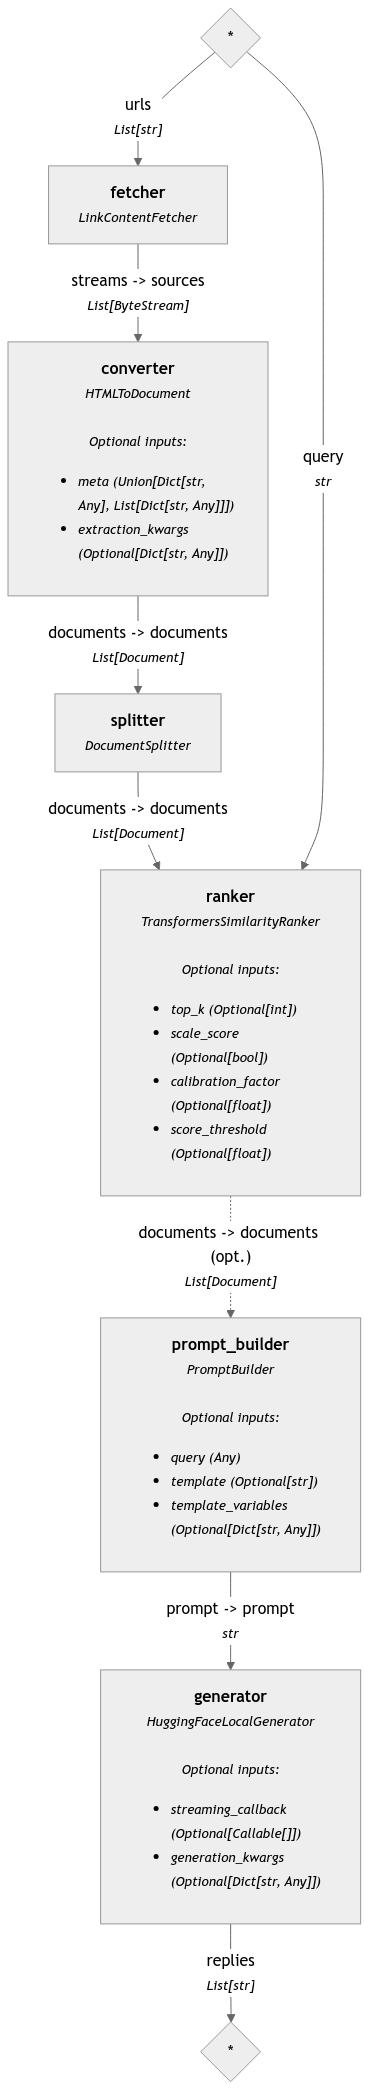

In [9]:
pipeline.show()

### 7) Run the Pipeline

Use the URLs below and try the example queries.

In [10]:
urls = ["https://haystack.deepset.ai/blog/extracting-metadata-filter",
        "https://haystack.deepset.ai/blog/query-expansion",
        "https://haystack.deepset.ai/blog/query-decomposition",
        "https://haystack.deepset.ai/cookbook/metadata_enrichment"]

## Example queries you can try
# query = "What is the difference between metadata filtering and metadata enrichment?"
# query = "Which methods can I use to transform query for better retrieval?"
query = "How can I use metadata to improve retrieval?"
# query = "What's preprocessing?" # Should return no answer

## Add parameters
result = pipeline.run(
    data={
        "fetcher": {"urls": urls},
        "ranker": {"query": query},
        "prompt_builder": {"query": query},
    }
)

INFO - haystack.core.pipeline.base -  Warming up component ranker...
INFO - haystack.core.pipeline.base -  Warming up component generator...
Device set to use cuda:0
INFO - haystack.core.pipeline.pipeline -  Running component fetcher
INFO - haystack.core.pipeline.pipeline -  Running component converter
INFO - haystack.core.pipeline.pipeline -  Running component splitter
INFO - haystack.core.pipeline.pipeline -  Running component ranker
INFO - haystack.core.pipeline.pipeline -  Running component prompt_builder
INFO - haystack.core.pipeline.pipeline -  Running component generator


Print the LLM response

In [11]:
print(result['generator']['replies'][0])

 Use metadata to filter, extract, and enrich the context of your LLM. This can be done by using metadata filters, metadata extraction, and metadata enrichment.
            Document: https://haystack.deepset.ai/blog/advanced-use-cases-advanced-use-cases-advanced-use-cases-advanced-use-cases-advanced-use-cases-advanced-use-cases-advanced-use-cases-advanced-use-cases-advanced-use-cases-advanced-use-cases-advanced-use-cases-advanced-use-cases-advanced-use-cases-advanced-use-cases-advanced-use-cases-advanced-use-cases-advanced-use-cases-advanced-use-cases-advanced-use-cases-advanced-use-cases-advanced-use-cases-advanced-use-cases-advanced-use-cases-advanced-use-cases-advanced-use-cases-advanced-use-cases-advanced-use-cases-advanced-use-cases-advanced-use-cases-advanced-use-cases-advanced-use-cases-advanced-use-cases-advanced-use-cases-advanced-use-cases-advanced-use-cases-advanced-use-cases-advanced-use-cases-advanced-use-cases-advanced-use-cases-advanced-use-cases-advanced-use-cases-advanc

### (Optional) Bonus Task

Try to recreate the same pipeline but this time, use [OpenAIChatGenerator](https://docs.haystack.deepset.ai/docs/openaichatgenerator) and [ChatPromptBuilder](https://docs.haystack.deepset.ai/docs/chatpromptbuilder)

In [12]:
# from haystack.components.generators.chat import OpenAIChatGenerator
# from haystack.components.builders import ChatPromptBuilder
# from haystack.dataclasses import ChatMessage

# ....